In [1]:
# Importing necessary libraries for building, training, and evaluating neural networks

import torch  # PyTorch library for tensor operations and building deep learning models
from torch import nn  # Neural network module from PyTorch to define and manage network layers and architectures
from torch.utils.data import DataLoader  # DataLoader to load datasets and handle batching
from torchvision import transforms, models  # Transformations for image preprocessing and augmentation, and pre-trained models
from torchvision.datasets import ImageFolder  # ImageFolder to load datasets where images are arranged in directories (one per class)
import numpy as np  # NumPy for numerical operations on arrays and matrices, essential for data manipulation
import matplotlib.pyplot as plt  # Matplotlib's pyplot for visualizing images, results, and model performance
from torch.utils.data import random_split  # random_split to split datasets into training and validation sets
from torch import optim  # Optimizers module from PyTorch for model training, supporting algorithms like SGD, Adam
from torchvision.models import resnet50, ResNet50_Weights  # Pre-trained ResNet50 model and associated weights from torchvision
from torchmetrics import Recall, Precision, Accuracy  # Metrics from torchmetrics to compute model evaluation metrics like recall, precision, and accuracy


In [2]:
# Define the image transformation pipeline to preprocess images for model input

transform = transforms.Compose([
    transforms.Resize(256),            # Resize the shorter side of the image to 256 pixels while maintaining aspect ratio
    transforms.CenterCrop(224),        # Crop the center of the image to 224x224 pixels
    transforms.ToTensor(),             # Convert the image to a PyTorch tensor (H x W x C -> C x H x W)
    transforms.Normalize(              # Normalize the image using ImageNet mean and standard deviation
        mean=[0.485, 0.456, 0.406],    # ImageNet mean values for RGB channels
        std=[0.229, 0.224, 0.225]      # ImageNet standard deviation values for RGB channels
    )
])


In [3]:
# Load the default pre-trained weights for ResNet50 from torchvision
weights = ResNet50_Weights.DEFAULT  

# Initialize the ResNet50 model with the pre-trained weights
model = resnet50(weights=weights)

# Modify the final fully connected (fc) layer to output 8 classes (e.g., for a custom classification task)
model.fc = nn.Linear(model.fc.in_features, 8)

# Get the image transformations associated with the pre-trained weights
transforma = weights.transforms  

# Freeze all layers except the final fully connected layer (fc) to prevent training of pre-trained layers
for param in model.parameters():  # Loop through all model parameters
    param.requires_grad = False  # Freeze parameters (no gradients computed for these layers)

# Unfreeze the last ResNet layer (layer4) for training
for param in model.layer4.parameters():  # Loop through parameters of layer4 (the last ResNet block)
    param.requires_grad = True  # Allow gradients to be computed for layer4 during backpropagation

# Unfreeze the parameters of the final fully connected layer (fc) for training
for param in model.fc.parameters():  # Loop through parameters of the fully connected layer
    param.requires_grad = True  # Allow gradients for the final layer


In [4]:
# Load the dataset from the specified directory using ImageFolder
dataset_images = ImageFolder(  
    'data/Micro_Organism',  # Path to the dataset directory containing subfolders (one per class)
    transform=transform  # Apply the defined image transformations (e.g., resizing, cropping, normalization)
)


In [5]:
# Calculate the size of the training dataset (80% of the total dataset)
train_size = int(0.8 * len(dataset_images))  

# Calculate the size of the validation dataset (remaining 20%)
val_size = len(dataset_images) - train_size  

# Split the dataset into training and validation sets
train_image, val_image = random_split(dataset_images, [train_size, val_size])  

In [6]:
# Create a DataLoader for the training set with a batch size of 16 and shuffling enabled
train_loader = DataLoader(train_image, batch_size=16, shuffle=True)  

# Create a DataLoader for the validation set with a batch size of 16 and shuffling enabled
val_loader = DataLoader(val_image, batch_size=16, shuffle=True)  

In [7]:
# Define the loss function (CrossEntropyLoss) for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) for model parameters with a learning rate of 0.1
optimizer = optim.Adam(model.parameters(), lr=0.1)


In [8]:
# Define the recall metric for multi-class classification with 8 classes
metric_recall = Recall(task='multiclass', num_classes=8)

# Define the precision metric for multi-class classification with 8 classes
metric_precision = Precision(task='multiclass', num_classes=8)

# Define the accuracy metric for multi-class classification with 8 classes
metric_acc = Accuracy(task='multiclass', num_classes=8)

# Initialize empty lists to store loss and accuracy values for training and validation
train_loss = []  # List to store training loss values
val_loss = []    # List to store validation loss values
train_acc = []   # List to store training accuracy values
val_acc = []     # List to store validation accuracy values


In [9]:
# Generate a range of 8 epochs using NumPy's arange function
epochs = np.arange(8)  # Create an array with values from 0 to 7 (8 epochs)

In [10]:

# Loop through the epochs for training
for epoch in epochs:  
    print(f"Starting Epoch {epoch+1}")  # Print the start of the epoch
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize the running loss for the current epoch

    # Reset the metrics for recall, precision, and accuracy
    metric_recall.reset()
    metric_precision.reset()
    metric_acc.reset()

    # Training phase
    for image, label in train_loader:  # Loop through batches in the training set
        optimizer.zero_grad()  # Zero the gradients before the backward pass
        output = model(image)  # Forward pass: compute model outputs
        _, pred = torch.max(output, 1)  # Get the predicted class by selecting the max output

        # Update the metrics
        metric_recall(pred, label)
        metric_precision(pred, label)
        metric_acc(pred, label)
        
        # Compute the loss and backpropagate
        loss = criterion(output, label)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update the model weights

        running_loss += loss.item()  # Accumulate the running loss

    # Compute the metrics at the end of the epoch
    train_recall = metric_recall.compute()  # Compute recall for training data
    train_precision = metric_precision.compute()  # Compute precision for training data
    train_accuracy = metric_acc.compute()  # Compute accuracy for training data
    train_loss.append(running_loss)  # Append the running loss to the train_loss list
    train_acc.append(train_accuracy)  # Append the training accuracy to the train_acc list

    # Validation phase
    running_val_loss = 0.0  # Initialize the running validation loss
    model.eval()  # Set the model to evaluation mode (turn off dropout, batch norm)
    with torch.no_grad():  # Disable gradient computation for validation
        for image, label in val_loader:  # Loop through batches in the validation set
            val_out = model(image)  # Forward pass for validation
            _, pred = torch.max(val_out, 1)  # Get the predicted class for validation

            loss1 = criterion(val_out, label)  # Compute the loss for validation
            running_val_loss += loss1.item()  # Accumulate the validation loss
            metric_recall(pred, label)  # Update recall metric
            metric_precision(pred, label)  # Update precision metric
            metric_acc(pred, label)  # Update accuracy metric

    # Compute the metrics for validation
    val_recall = metric_recall.compute()  # Compute recall for validation data
    val_precision = metric_precision.compute()  # Compute precision for validation data
    val_accuracy = metric_acc.compute()  # Compute accuracy for validation data
    val_loss.append(running_val_loss)  # Append the running validation loss to the val_loss list
    val_acc.append(val_accuracy)

    # Print the metrics after each epoch
    print(f'Epoch [{epoch+1}/8], Loss: {running_loss}')  # Print the total training loss for the epoch
    print(f'Epoch [{epoch+1}/8], Training Recall: {train_recall}, Validation Recall: {val_recall}')  # Print recall for both training and validation
    print(f'Epoch [{epoch+1}/8], Training Precision: {train_precision}, Validation Precision: {val_precision}')  # Print precision for both training and validation
    print(f'Epoch [{epoch+1}/8], Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')  # Print accuracy for both training and validation


Starting Epoch 1
Epoch [1/8], Loss: 456.4863271713257
Epoch [1/8], Training Recall: 0.3787638545036316, Validation Recall: 0.3929024040699005
Epoch [1/8], Training Precision: 0.3787638545036316, Validation Precision: 0.3929024040699005
Epoch [1/8], Training Accuracy: 0.3787638545036316, Validation Accuracy: 0.3929024040699005
Starting Epoch 2
Epoch [2/8], Loss: 65.71822094917297
Epoch [2/8], Training Recall: 0.6212361454963684, Validation Recall: 0.6096324324607849
Epoch [2/8], Training Precision: 0.6212361454963684, Validation Precision: 0.6096324324607849
Epoch [2/8], Training Accuracy: 0.6212361454963684, Validation Accuracy: 0.6096324324607849
Starting Epoch 3
Epoch [3/8], Loss: 55.86747106909752
Epoch [3/8], Training Recall: 0.7131537199020386, Validation Recall: 0.6907477974891663
Epoch [3/8], Training Precision: 0.7131537199020386, Validation Precision: 0.6907477974891663
Epoch [3/8], Training Accuracy: 0.7131537199020386, Validation Accuracy: 0.6907477974891663
Starting Epoch 4

In [11]:
print(val_acc)

[tensor(0.3929), tensor(0.6096), tensor(0.6907), tensor(0.7630), tensor(0.7858), tensor(0.8289), tensor(0.8479), tensor(0.8758)]


In [12]:
print(train_loss)

[456.4863271713257, 65.71822094917297, 55.86747106909752, 38.44070391356945, 27.86033894121647, 22.734419399872422, 13.011189078912139, 9.19024256709963]


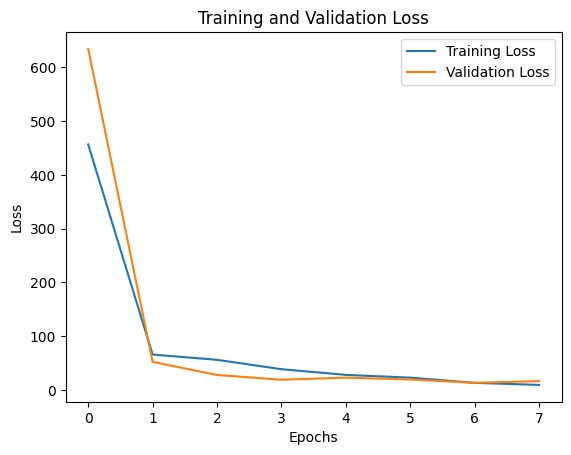

In [13]:

# Plot the training loss over epochs
plt.plot(epochs, train_loss, label='Training Loss')

# Plot the validation loss over epochs
plt.plot(epochs, val_loss, label='Validation Loss')

# Add a legend to differentiate between training and validation loss
plt.legend()

# Add labels and title
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')    # Label for the y-axis
plt.title('Training and Validation Loss')  # Title of the plot

# Show the plot
plt.show()

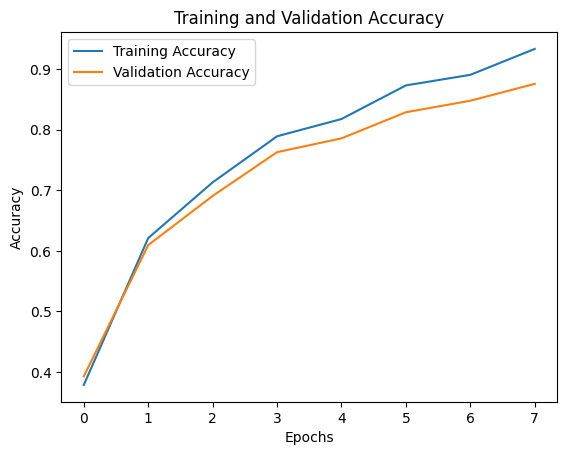

In [14]:

# Plot the training loss over epochs
plt.plot(epochs, train_acc, label='Training Accuracy')

# Plot the validation loss over epochs
plt.plot(epochs, val_acc, label='Validation Accuracy')

# Add a legend to differentiate between training and validation loss
plt.legend()

# Add labels and title
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Accuracy')    # Label for the y-axis
plt.title('Training and Validation Accuracy')  # Title of the plot

# Show the plot
plt.show()